# ベースライン (LightGBM)

Predicting Road Accident Risk (Playground Series - Season 5, Episode 10)

https://www.kaggle.com/competitions/playground-series-s5e10/overview

In [1]:
from time import time

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from utils import check_df, elapsed_time

In [2]:
start = time()

## パラメータ設定

In [3]:
class CFG:
    seed = 123

## データ読み込み

In [4]:
class Paths:
    p = "./input/"
    train = p + "train.csv"
    test = p + "test.csv"
    sample = p + "sample_submission.csv"
    submission = "./output/exp03.csv"

In [5]:
train = pd.read_csv(Paths.train)
train.shape

(517754, 14)

In [6]:
check_df(train)

,Column,dtypes,NaN Count,Nunique,Unique Values
0,id,int64,0,517754,> 10 unique values
1,road_type,object,0,3,"[urban, rural, highway]"
2,num_lanes,int64,0,4,"[2, 4, 1, 3]"
3,curvature,float64,0,261,> 10 unique values
4,speed_limit,int64,0,5,"[35, 70, 60, 45, 25]"
5,lighting,object,0,3,"[daylight, dim, night]"
6,weather,object,0,3,"[rainy, clear, foggy]"
7,road_signs_present,bool,0,2,"[False, True]"
8,public_road,bool,0,2,"[True, False]"
9,time_of_day,object,0,3,"[afternoon, evening, morning]"


## データ分割

In [7]:
# x_train = train_df.drop(columns=["accident_risk"])
features = ["num_lanes", "curvature", "speed_limit", "num_reported_accidents"]
target = "accident_risk"
x_train = train[features]
y_train = train[target]

<Axes: >

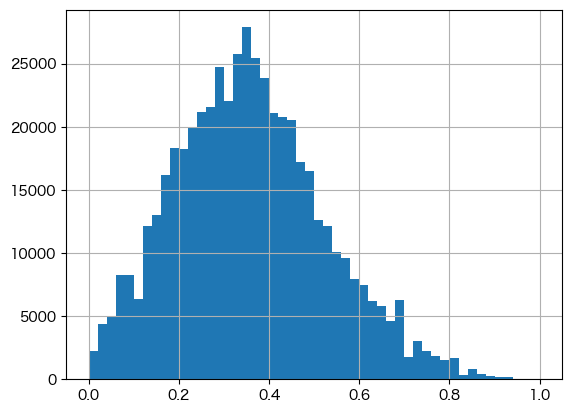

In [8]:
train[target].hist(bins=50)

## クロスバリデーション

In [9]:
params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.1,
    "num_leaves": 16,
    "n_estimators": 100000,
    "random_state": CFG.seed,
    "verbose": -1,
}

In [10]:
n_splits = 5
cv = KFold(n_splits=n_splits, shuffle=True, random_state=CFG.seed)

metrics = []
imp = pd.DataFrame()

for fold, (train_idx, val_idx) in enumerate(cv.split(x_train, y_train)):
    print("=" * 10, f"Fold {fold + 1}", "=" * 10)
    x_tr, y_tr = x_train.iloc[train_idx], y_train.iloc[train_idx]
    x_va, y_va = x_train.iloc[val_idx], y_train.iloc[val_idx]

    model = lgb.LGBMRegressor(**params)

    model.fit(
        x_tr,
        y_tr,
        eval_set=[(x_tr, y_tr), (x_va, y_va)],
        eval_metric="rmse",
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=False),
            lgb.log_evaluation(100),
        ],
    )

    y_tr_pred = model.predict(x_tr)
    y_va_pred = model.predict(x_va)

    rmse_tr = np.sqrt(mean_squared_error(y_tr, y_tr_pred))
    rmse_va = np.sqrt(mean_squared_error(y_va, y_va_pred))

    metrics.append([fold + 1, rmse_tr, rmse_va])

    _imp = pd.DataFrame(
        {
            "feature": x_train.columns,
            "importance": model.feature_importances_,
            "fold": fold + 1,
        }
    )
    imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

========== Fold 1 ==========
[100]	training's rmse: 0.106171	valid_1's rmse: 0.106282
[200]	training's rmse: 0.105925	valid_1's rmse: 0.106126
[300]	training's rmse: 0.105811	valid_1's rmse: 0.106089
[400]	training's rmse: 0.105741	valid_1's rmse: 0.106077
[500]	training's rmse: 0.105684	valid_1's rmse: 0.106077
========== Fold 2 ==========
[100]	training's rmse: 0.10626	valid_1's rmse: 0.105951
[200]	training's rmse: 0.106018	valid_1's rmse: 0.105779
[300]	training's rmse: 0.105913	valid_1's rmse: 0.105732
[400]	training's rmse: 0.105837	valid_1's rmse: 0.105715
[500]	training's rmse: 0.105778	valid_1's rmse: 0.105715
[600]	training's rmse: 0.105734	valid_1's rmse: 0.105721
========== Fold 3 ==========
[100]	training's rmse: 0.106243	valid_1's rmse: 0.106
[200]	training's rmse: 0.106016	valid_1's rmse: 0.105836
[300]	training's rmse: 0.105905	valid_1's rmse: 0.105792
[400]	training's rmse: 0.105827	valid_1's rmse: 0.105778
[500]	training's rmse: 0.105757	valid_1's rmse: 0.105779
=====

In [11]:
metrics_array = np.array(metrics)

print(
    "[cv ] tr: {:.5f} ± {:.5f}, va: {:.5f} ± {:.5f}".format(
        metrics_array[:, 1].mean(),
        metrics_array[:, 1].std(),
        metrics_array[:, 2].mean(),
        metrics_array[:, 2].std(),
    )
)

[cv ] tr: 0.10572 ± 0.00007, va: 0.10602 ± 0.00025


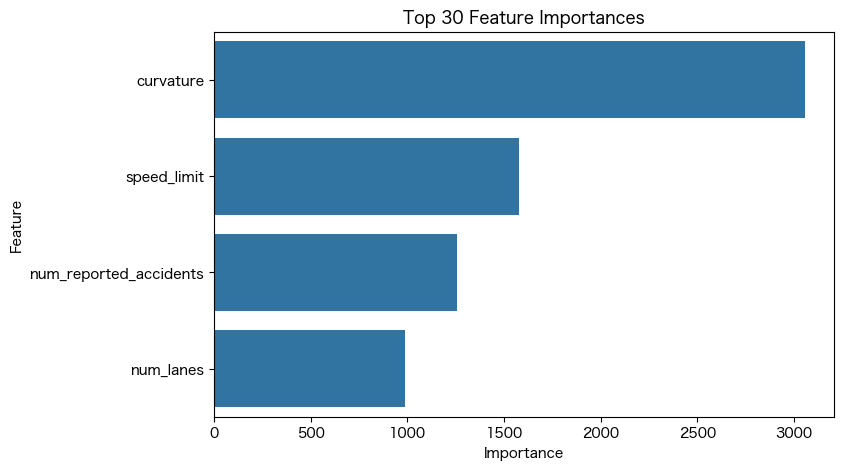

In [12]:
imp = imp.groupby("feature")["importance"].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=imp.head(30).values, y=imp.head(30).index)
plt.title("Top 30 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

## 予測・提出

In [13]:
test = pd.read_csv(Paths.test)
x_test = test[features]
x_test.shape

(172585, 4)

In [14]:
submit = pd.read_csv(Paths.sample)
submit.head()

,id,accident_risk
0,517754,0.352
1,517755,0.352
2,517756,0.352
3,517757,0.352
4,517758,0.352


In [15]:
y_test_preds = model.predict(x_test)

df_submit = pd.DataFrame({
    "id": test["id"],
    "accident_risk": y_test_preds
})

In [16]:
df_submit.to_csv(Paths.submission, index=False)

In [17]:
hours, minutes, seconds = elapsed_time(start)
print(f"Elapsed time: {hours}h {minutes}m {seconds}s")

Elapsed time: 0h 0m 19s
